<a href="https://colab.research.google.com/drive/1W7apBKuj6rtr55d-qVvl7GXTBiapf105?usp=sharing" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformeur : génération de melodies

#### Importations

In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt
import math

In [2]:
#path local
sys.path.append('C:/Users/jeffs/Desktop/M2')
sys.path.append('C:/Users/jeffs/Desktop/M2/data')
sys.path.append('C:/Users/jeffs/Desktop/M2/Transformer')

In [3]:
from melodygenerator import *
from melodypreprocessor import *
from train import *
from transformer import *
from extract_data import *
from visualization import *

### Extraction des données des fichiers xml

In [4]:
'''
#Extractions des partitions a partir des fichiers xml
path_to_xml= "data/data_xml"
file_output= "data/data.json"

D= data_to_json(path_to_xml)
with open(file_output, 'w',encoding="utf-8") as f:
    json.dump(D,f,indent=2)
print(f'{file_output} with {len(D)} scores created.')
'''

'\n#Extractions des partitions a partir des fichiers xml\npath_to_xml= "data/data_xml"\nfile_output= "data/data.json"\n\nD= data_to_json(path_to_xml)\nwith open(file_output, \'w\',encoding="utf-8") as f:\n    json.dump(D,f,indent=2)\nprint(f\'{file_output} with {len(D)} scores created.\')\n'

### Extractions des mélodies

In [5]:
'''
#Extraction des melodies par partie
filename="dataset"
size_melody= 3 #en mesure ( 1000 = max de la partie )
time_signatures=set(["2/4"]) #prend toutes les time signatures par default

parts_len=json_into_part_melody("data/data.json",output_file=filename,size=size_melody,time_signatures=time_signatures)
print("Toutes les melodies ont étés générées par parties. Tailles des parties : "+" ".join([f"{key} : {length} " for key,length in parts_len]))
'''

'\n#Extraction des melodies par partie\nfilename="dataset"\nsize_melody= 3 #en mesure ( 1000 = max de la partie )\ntime_signatures=set(["2/4"]) #prend toutes les time signatures par default\n\nparts_len=json_into_part_melody("data/data.json",output_file=filename,size=size_melody,time_signatures=time_signatures)\nprint("Toutes les melodies ont étés générées par parties. Tailles des parties : "+" ".join([f"{key} : {length} " for key,length in parts_len]))\n'

### Création du modèle

In [6]:
melody_preprocessor = MelodyPreprocessor("data/dataset3A.json", batch_size=32)
train_dataset = melody_preprocessor.create_training_dataset()
vocab_size = melody_preprocessor.number_of_tokens_with_padding
transformer_model = Transformer(
    num_layers=2,
    d_model=64,
    num_heads=2,
    d_feedforward=128,
    input_vocab_size=vocab_size,
    target_vocab_size=vocab_size,
    max_num_positions_in_pe_encoder=384,
    max_num_positions_in_pe_decoder=384,
    dropout_rate=0.2,
)
nb_batchs=len(train_dataset)

### Entrainement du modèle

In [7]:
iters,losses=train(train_dataset, transformer_model,2)

Training the model...
Epoch 1 Batch 1 Loss 5.750909805297852
Epoch 1 Batch 2 Loss 5.366855621337891
Epoch 1 Batch 3 Loss 5.012927532196045
Epoch 1 Batch 4 Loss 4.987311363220215
Epoch 1 Batch 5 Loss 4.810332298278809
Epoch 1 Batch 6 Loss 4.808162689208984
Epoch 1 Batch 7 Loss 4.5888190269470215
Epoch 1 Batch 8 Loss 4.574037075042725
Epoch 1 Batch 9 Loss 4.420665264129639
Epoch 1 Batch 10 Loss 4.435194969177246
Epoch 1 Batch 11 Loss 4.288411617279053
Epoch 1 Batch 12 Loss 4.1843976974487305
Epoch 1 Batch 13 Loss 4.197107315063477
Epoch 1 Batch 14 Loss 4.162227153778076
Epoch 1 Batch 15 Loss 4.213158130645752
Epoch 1 Batch 16 Loss 4.157118320465088
Epoch 1 Batch 17 Loss 4.05126428604126
Epoch 1 Batch 18 Loss 3.929335355758667
Epoch 1 Batch 19 Loss 4.0944414138793945
Epoch 1 Batch 20 Loss 3.988893508911133
Epoch 1 Batch 21 Loss 3.8789265155792236
Epoch 1 Batch 22 Loss 3.9855778217315674
Epoch 1 Batch 23 Loss 3.9298195838928223
Epoch 1 Batch 24 Loss 4.079962253570557
Epoch 1 Batch 25 Loss 

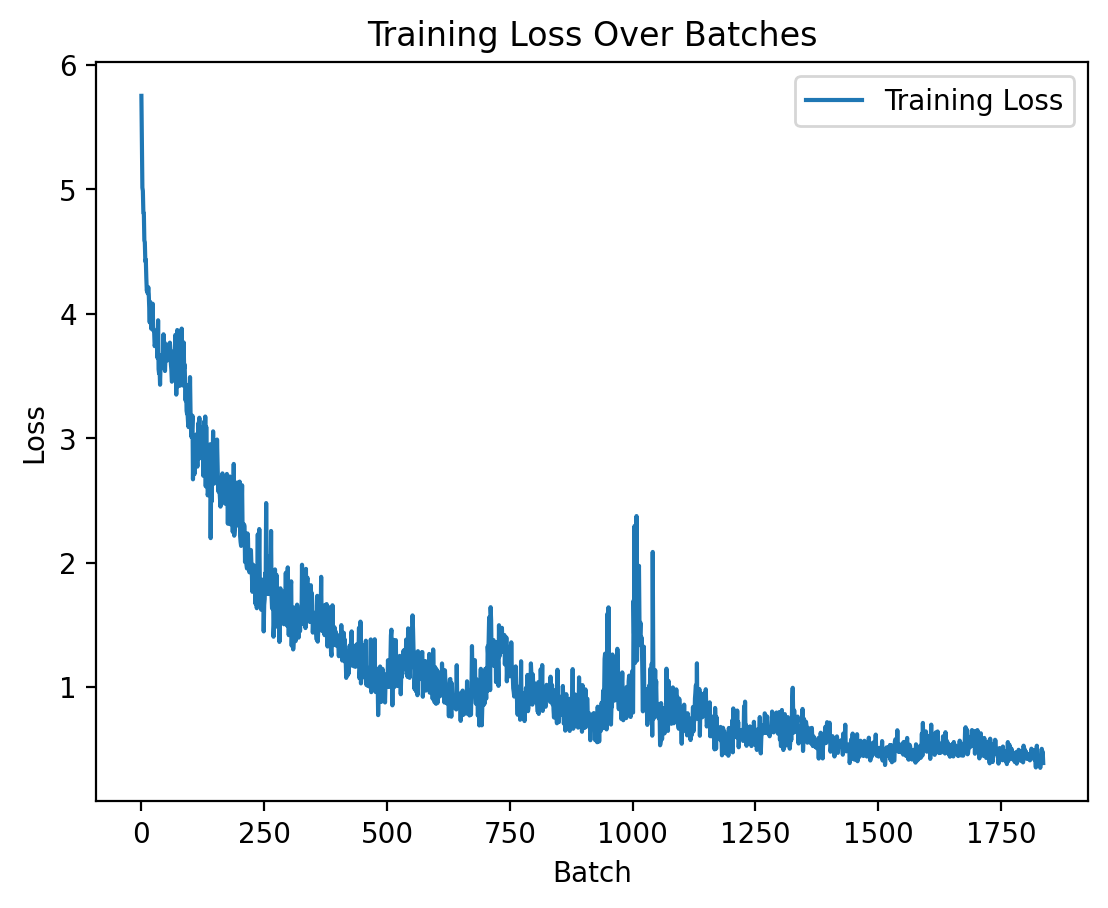

In [8]:
def plot_losses(iters,losses,batchs):
    plt.plot(iters,losses, label='Training Loss')
    for i in range(batchs,len(iters),batchs):
        plt.axvline(x=i, color='r', linestyle='--', linewidth=1)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Batches')
    plt.legend()
    plt.show()

plot_losses(iters,losses,nb_batchs)

### Génération

### Parametres

In [9]:
melodie_size = 3
lg_debut = 2 #Nombre de mesures pour la sequence initiale
lg_predict = 1 #Nombre de mesures pour la sequence prédite
nb_melodies= 10
max_notes = 20+8*lg_predict

MODE_DECALAGE=True #On prend lg_debut mesure de l'original pour prédire lg_predict et on decale

mode=2 #0 highest prob   #2 categorical + temperature + topk sampling
forcing=0.9  #entre 0 et 1, pourcentage de chance d'utiler les notes extraites de l'originale lors de la prédiction

melody_generator = MelodyGenerator(
    transformer_model, melody_preprocessor.tokenizer,max_notes
)

In [10]:
error_part_A= ['Sarau para Radamés','DESPREZADO','ACARICIANDO','Dino Pintando o Sete Cordas','Ja Te Digo','CHORANDO']
melodies_generated=[]
mode=0 #0 highest prob   #2 categorical + temperature + topk sampling
forcing=0.5  #entre 0 et 1, pourcentage de chance d'utiler les notes extraites de l'originale lors de la prédiction


for _ in range(nb_melodies):
  print("Generating a melody...")
  seq=extract_random_seq("assets/data.json",1,"A")
  print(f'Titre de l_original : {seq[0]}')
  original= extract_seq_from("assets/data.json",seq[0],seq[2],mode="mesure")[-1]

  #Tant que la partie extraite ne correspond pas a la time signature ou quelle contient des mesures vides ( a fix)
  while seq[1]!= "2/4" or (seq[0] in error_part_A and MODE_DECALAGE):
      seq=extract_random_seq("assets/data.json",1,"A")
      original= extract_seq_from("assets/data.json",seq[0],seq[2],mode="mesure")[-1]


  if MODE_DECALAGE:
      new_melody,p = generate_decalage(melody_generator,original,2,1,mode=mode,k=10,first_proba=0.8)
      p = [ prob for proba in p for prob in proba][:len(new_melody)]
      original=[ n for m in original for n in m]
  else:
      debut= original[:lg_debut]
      debut=[ n for m in debut for n in m]
      print(f'Sequence de départ : {debut}')
      original=[ n for m in original for n in m]
      #new_melody
      new_melody,p = melody_generator.generate(debut,forcing=forcing,melody=original,mode=mode,k=10,first_proba=0.6)
      new_melody=new_melody.split(' ')
      new_melody=n_measure(new_melody,lg_predict+lg_debut,"2/4")
           
      melody_lenght= len(new_melody)
      #proba
      p= [1]*len(debut)+p
      p=p[:melody_lenght]
  melodies_generated.append((seq,new_melody,original,p))
  print(new_melody)
  print(len(new_melody))
  print(len(p),p)
  
  print('---------------------')

print('Génération terminée')



Generating a melody...
Titre de l_original : SAPECA
Nombre de mesures dans l'original : 16
Mesure 3 : generated
Mesure 4 : generated
Mesure 5 : generated
Mesure 6 : generated
Mesure 7 : generated
Mesure 8 : generated
Mesure 9 : generated
Mesure 10 : generated
Mesure 11 : generated
Mesure 12 : generated
Mesure 13 : generated
Mesure 14 : generated
Mesure 15 : generated
Mesure 16 : generated
Melodie generated
['C#5-0.25', 'A4-0.5', 'A4-0.25', 'E5-0.25', 'E5-0.25', 'D5-0.5', 'D5-0.25', 'A4-0.5', 'A4-0.25', 'F5-0.25', 'F5-0.25', 'E5-0.5', 'E5-0.25', 'A4-0.25', 'E5-0.25', 'A4-0.25', 'E5-0.25', 'A4-0.25', 'A4-0.5', 'D5-0.25', 'A4-0.5', 'A4-0.25', 'F5-0.25', 'A4-0.25', 'E5-0.25', 'A4-0.25', 'A5-0.25', 'E5-0.25', 'A4-0.25', 'G5-0.25', 'A4-0.25', 'E5-0.25', 'A4-0.25', 'A4-0.25', 'F#5-0.25', 'D5-0.25', 'D5-0.5', 'D5-0.25', 'D5-0.5', 'A5-0.25', 'G5-0.25', 'B-4-0.25', 'D5-0.5', 'B-4-0.25', 'G4-0.25', 'B-4-0.25', 'E5-0.25', 'D5-0.25', 'B-4-0.25', 'D5-0.25', 'A4-0.5', 'D5-0.25', 'B-4-0.5', 'G5-0.25',

#### Enregistrement

In [11]:
 generated = [ {'Title' : s[0] , "Time_signature" : s[1], 'Part': s[2], 'Key' : s[3] ,'Generated' : m , 'Original' : o , 'Proba' : [] if mode ==0 else [ str(prob) for prob in p ]} for (s,m,o,p) in melodies_generated ]

In [12]:
file_output='melody3_' if MODE_DECALAGE else ''
file_output+=f'mode{mode}'
file_output+=f'_top{top_k}' if mode==2 else ''
file_output+=f'_forcing{forcing}' if forcing>0 else ''
print(file_output)

with open(f'Generated/Transformer/{file_output}.json',"w") as f:
    json.dump(generated,f,indent=2)

## Visualisation

In [13]:
import music21
from music21 import *

#### Toutes les melodies generées

In [14]:
show_all_generated(f"Generated/Transformer/{file_output}.json").show("musicxml")

#### Comparer melodie i avec l'original

In [15]:
num_melodie=1
score=compare_generated(num_melodie, file_name=f"Generated/Transformer/{file_output}.json")
score.show("musicxml")